<a href="https://colab.research.google.com/github/ougrid/Radio_astronomy_tutorial/blob/main/AIAT_tutorial_transient_search_TH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/thepetabyteproject/your.git
!pip install -U git+https://github.com/FRBs/sigpyproc3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/thepetabyteproject/your.git to /tmp/pip-req-build-w3wde8vr
  Running command git clone --filter=blob:none --quiet https://github.com/thepetabyteproject/your.git /tmp/pip-req-build-w3wde8vr
  Resolved https://github.com/thepetabyteproject/your.git to commit 8845cafd2abcf373e9fb2fe4e9f230633ea9fac5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 3.4 MB/s eta 0:00:00
  Created wheel for your: filename=your-0.6.7-py3-none-any.whl size=86104 sha256=e7ae2a9fbe5ba9a2b8c16735091042fb0018f9e342e9b330b3935eecc37713dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-f4g2h5i9/wheels/e9/29/47/7971d2558f135c274ccdef8f73460d37d1cacaaac1e5fc428d
Successfully built your
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab

In [ ]:
from your.candidate import Candidate
from your.utils.plotter import plot_h5
import numpy as np
from scipy.signal import detrend
import os
import tempfile
from urllib.request import urlretrieve
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [ ]:
import pylab as plt
import logging
import numpy as np
from rich.pretty import Pretty
from sigpyproc.readers import FilReader

#Matched filter 


A matched filter is a signal processing technique used to enhance the detection of a specific signal in the presence of background noise. It works by comparing a received signal with a known template signal, which is a replica of the signal that was transmitted. The received signal and the template signal are convolved together, which is a mathematical operation that effectively correlates the two signals. The output of this operation is a signal that has a high amplitude at the time instances where the received signal and the template signal are similar.

Imagine you are trying to listen to a song on the radio, but there is static and other songs playing at the same time, making it difficult to hear the song you want. A matched filter would be like a filter that you apply to the radio signal, that would enhance the song you want and reduce the effect of the noise and other songs.

Matched filters are commonly used in various fields such as radar, sonar and communication systems, to improve signal detection and estimation. -- ChatGPT

A matched filter is like a special helper that makes it easier to find a certain sound or signal, like a whistle, in a noisy place like a playground. Just like how you use your ears to find where the sound is coming from, the matched filter uses a special tool to make the sound louder and easier to hear. This way, we can find the sound we want even if there are other sounds around. It's like using a magnifying glass to find something small in a big field.- Also ChatGPT, but for 5 years old.  

In [ ]:
from scipy.signal import convolve,gaussian
import numpy as np 

จำลองสัญญาณจาก Random uniform distribution noise 

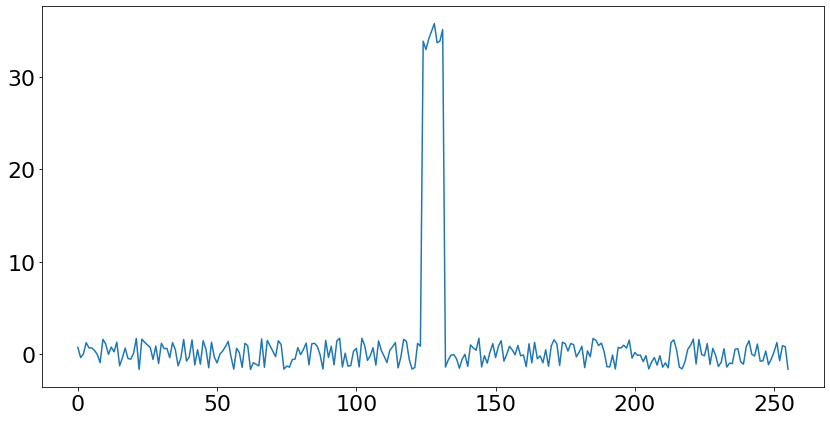

In [ ]:
w = 8 #@param {type:"slider", min:0, max:10, step:1}
length=128
noise=np.random.uniform(size=length*2)-0.5
std=np.std(noise)
a = 10 #@param {type:"slider", min:0, max:10, step:1}
noise[length-w//2:length+w//2]=noise[length-w//2:length+w//2]+a
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(noise/std)
noise=noise/std

1 0
2 1
4 2
8 4
16 8


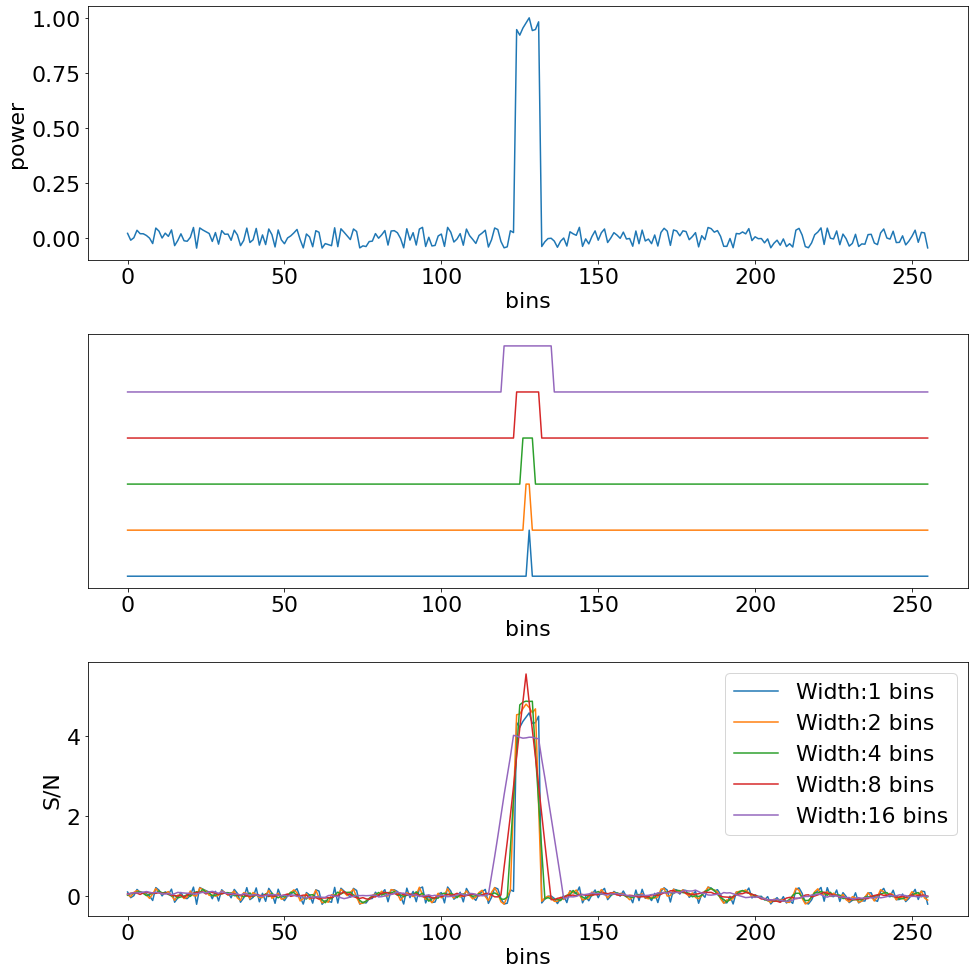

In [ ]:
plt.rcParams["figure.figsize"] = (14,14)
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(3)
s=[]
axs[0].plot(noise/noise.max())
for i in [1,2,4,8,16]:
    
    r=np.int32(np.round(i/2))
    print(i,r)
    epro=np.zeros(length*2)
    epro[0:i]=np.ones(i)+epro[0:i]
    axs[1].plot(np.roll(epro,length-r)+np.log2(i))
    p=convolve(1/np.ones(i),noise,mode='full')[r:r+length*2]
    n=p[125:i+length*2].std()
    s.append(n)
    axs[2].plot(p/n,label='Width:'+str(i)+' bins')
axs[2].legend()
axs[2].set_xlabel('bins')
axs[1].set_xlabel('bins')
axs[0].set_xlabel('bins')
axs[2].set_ylabel('S/N')
axs[0].set_ylabel('power')
axs[1].set_yticks([])
plt.tight_layout()

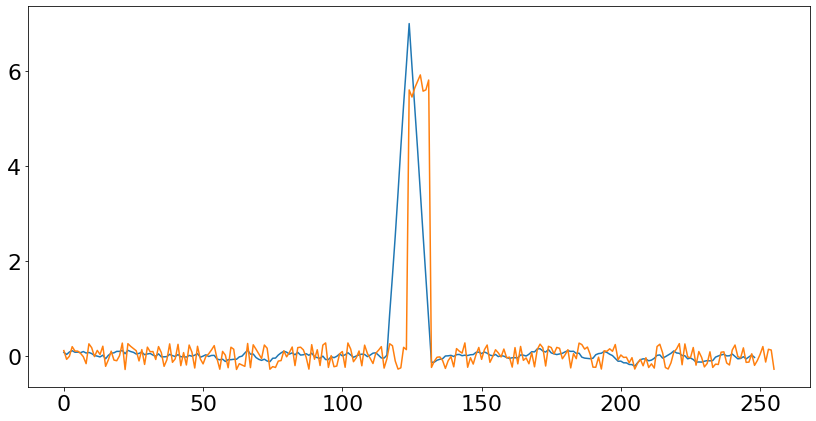

In [ ]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(convolve(1/np.ones(8),noise,mode='valid')/convolve(1/np.ones(8),noise,mode='valid').std())
plt.plot(noise/noise.std())

จะเห็นว่า เมื่อ width ของ template เท่ากับ width ของสัญญาณ สัญญาณจะมีค่ามากขึ้น

EX1: ถ้าสัญญาณมีความกว้าง (W) 6 bins เมื่อทำ match filters จะได้ S/N มากที่สุด ที่ ความกว้างของ Template width เท่าไหร่ ? 

#เตรียมข้อมูล

In [ ]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/FRB180417.fil"
url = "https://zenodo.org/record/3905426/files/FRB180417.fil"
urlretrieve(
    url,
    download_path,
)
fil_file = download_path

In [ ]:
myFil = FilReader(fil_file) # อ่านไฟล์

In [ ]:
Pretty(myFil.header)

Header(
    filename='/tmp/tmpkoooe5zp/FRB180417.fil',
    data_type='filterbank',
    nchans=336,
    foff=-1.0,
    fch1=1465.0,
    nbits=8,
    tsamp=0.00126646875,
    tstart=58682.620316710374,
    nsamples=5120,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (186.656817, 13.96447557)>,
    azimuth=<Angle 0. deg>,
    zenith=<Angle 0. deg>,
    telescope='GMRT',
    backend='FAKE',
    source='src1',
    frame='topocentric',
    ibeam=0,
    nbeams=0,
    dm=0,
    period=0,
    accel=0,
    signed=False,
    rawdatafile='ics_beams/28.fil',
    hdrlens=[327],
    datalens=[1720320],
    filenames=['/tmp/tmpkoooe5zp/FRB180417.fil'],
    nsamples_files=[5120],
    tstart_files=[58682.620316710374]
)

EX2: ข้อมูลนี้ มี Sampling time (tsamp) กี่ วินาที แล้วมีจำนวณข้อมูล (nsamples) เท่าไหร่ ?

ต่อไป เราจะลอง dedisperse ข้อมูล ที่ DM= 0 $pc/cm^3$

In [ ]:
%%time
myTim = myFil.dedisperse(0)


Output()

CPU times: user 188 ms, sys: 37.5 ms, total: 225 ms
Wall time: 262 ms


Text(0.5, 1.0, 'Timeseries at DM=0 $pc/cm^3$')

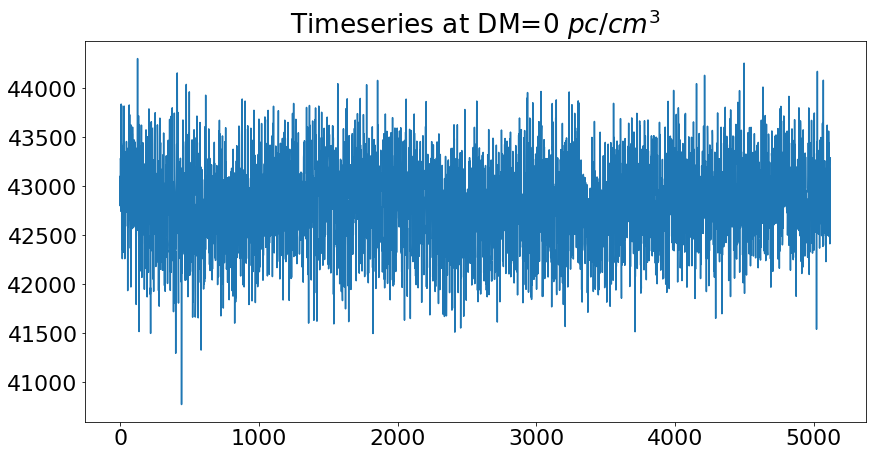

In [ ]:
plt.plot(myTim)
plt.title('Timeseries at DM=0 $pc/cm^3$')

ต่อไป เราจะ dedisperse data ของเรา ตั้งแต่ DM=0 ถึง DM=500 $pc/cm^3$

In [ ]:
%%time
dedisperse_timeseries=[]
dm_step=np.arange(0,525,25)
for i in dm_step:
  dedisperse_timeseries.append(myFil.dedisperse(i))

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

CPU times: user 2.27 s, sys: 65.6 ms, total: 2.34 s
Wall time: 3.04 s


แปลงข้อมูลที่ได้ เป็น numpy assay 

In [ ]:
np_dedisperse_timeseries=np.asarray(dedisperse_timeseries)

<ipython-input-28-62aef5fa70a5>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_dedisperse_timeseries=np.asarray(dedisperse_timeseries)


ลอง Plot timeseries ที่ได้ ณ DM ต่างๆ เช่น 450,475,500 $pc/cm^3$

Text(0.5, 1.0, 'Timeseries at DM= 450 $pc/cm^3$')

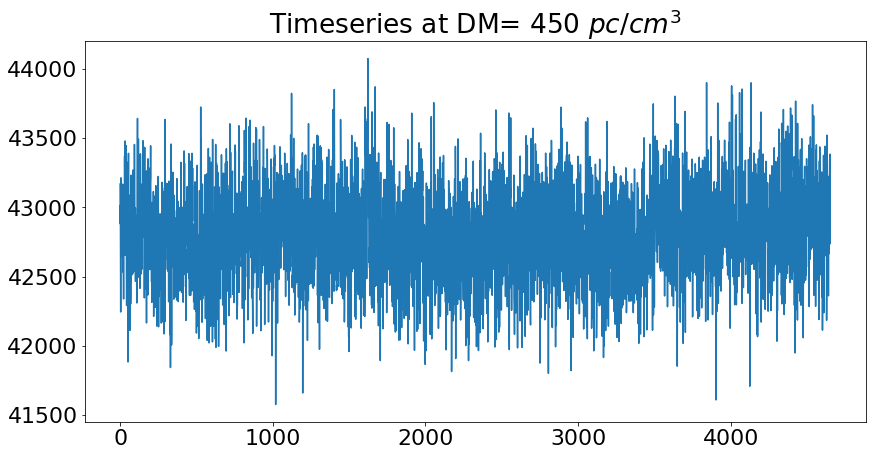

In [ ]:
plt.plot(np_dedisperse_timeseries[18])
plt.title('Timeseries at DM= '+str(dm_step[18])+' $pc/cm^3$')

Text(0.5, 1.0, 'Timeseries at DM= 475 $pc/cm^3$')

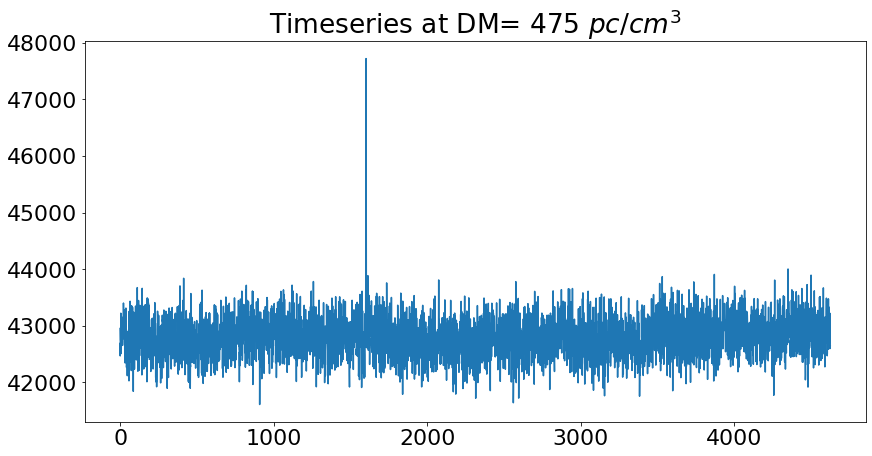

In [ ]:
plt.plot(np_dedisperse_timeseries[19])
plt.title('Timeseries at DM= '+str(dm_step[19])+' $pc/cm^3$')

Text(0.5, 1.0, 'Timeseries at DM= 500 $pc/cm^3$')

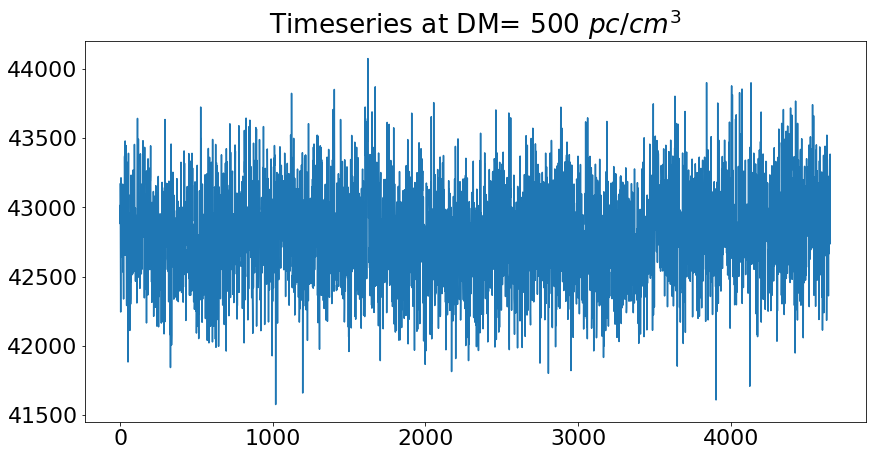

In [ ]:
plt.plot(np_dedisperse_timeseries[18])
plt.title('Timeseries at DM= '+str(dm_step[20])+' $pc/cm^3$')

Text(0.5, 1.0, 'Timeseries at DM= 250 $pc/cm^3$')

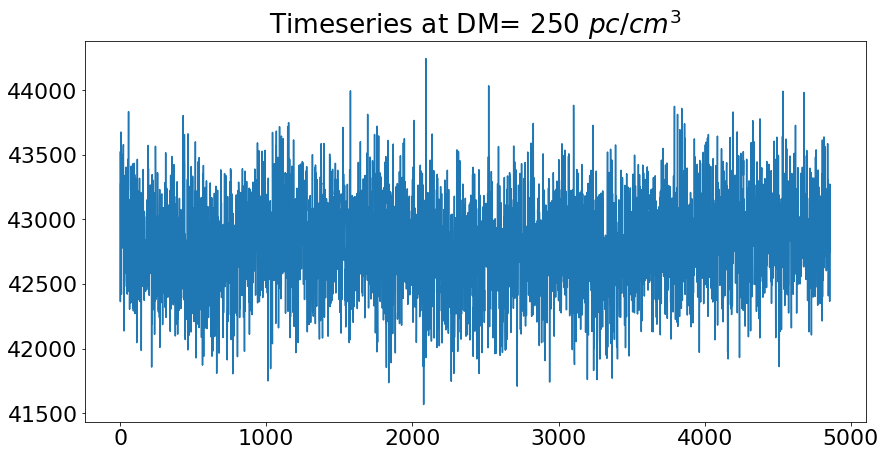

In [ ]:
plt.plot(np_dedisperse_timeseries[10])
plt.title('Timeseries at DM= '+str(dm_step[10])+' $pc/cm^3$')

เพียงเท่านี้เราก็จะเห็นสัญญาณดังกล่าวแล้ว อย่างไรก็ตาม ในกรณีที่สัญญาณ FRB มีค่าความสว่างน้อยกว่านี้ เราสามารถหาสัญญาณเหล่านี้ได้ด้วย matched filters 

EX3: โดยปรกติ นักดาราศาสตร์จะหา DM ตั้งแต่ 0 ถึง 1000 $pc/cm^{3}$ โดยมี stepsize 1 $pc/cm^{3}$ จะใช้เวลาทั้งหมดเท่าไหร่ ? 

# Searching for radio pulses 

ในหัวข้อที่แล้ว เราได้รู้ว่าการใช้ Matched filter สามารถทำให้สามารถจับสัญญาณได้มากขึ้น แต่ว่า เราก็ต้องทำการ de-dispersion เพื่อชดเชยการ delay ที่เกิดจากสะสารเคลื่อนที่ผ่านพลาสม่าในอวกาศ ตอนนี้ เราจะมาลองจับสัญญาณจริงๆ จากอวกาศกัน

In [ ]:
%%time
width=[]
i_array=[1, 2, 4, 8, 16, 32, 64]
for i in i_array:
    # Perform the convolution and calculate the width
    p = convolve(1/np.ones(i), np_dedisperse_timeseries[19], mode='valid')
    width.append((p-np.median(p))/p.std())

CPU times: user 4.04 ms, sys: 0 ns, total: 4.04 ms
Wall time: 7.73 ms


Text(0.5, 1.0, 'A result form filter with width of 64 bins ')

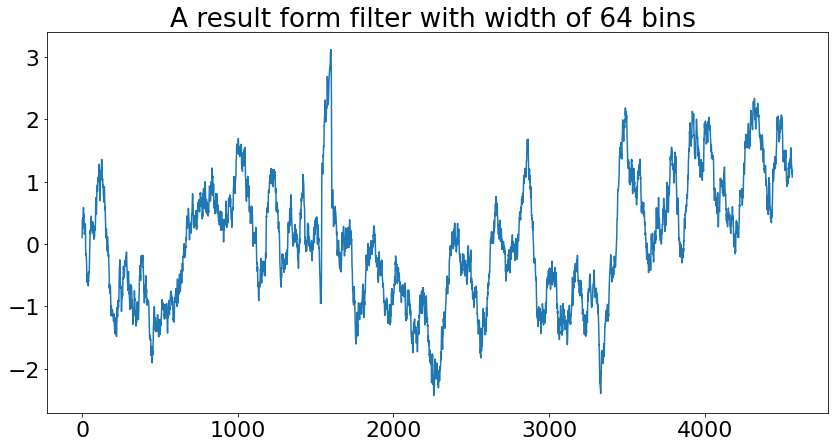

In [ ]:
plt.plot(width[6])
plt.title("A result form filter with width of "+str(i_array[6])+" bins ")

Text(0.5, 1.0, 'A result form filter with width of 2 bins ')

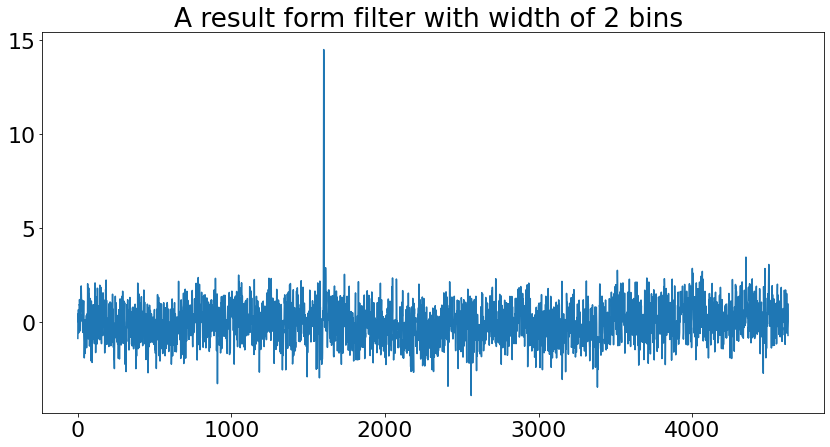

In [ ]:
plt.plot(width[1])
plt.title("A result form filter with width of "+str(i_array[1])+" bins ")

แต่เราจะรู้ได้อย่างไรละ ว่า S/N ที่เราได้นี้ ไม่ได้เกิดมาจาก random noise ? โดยวิธีการที่เราจะทำนั้น ก็คือ ให้ assume ว่า data ของเรานั้น มีการแจกแจงแบบปรกติ (Normal distribution)

Text(0.5, 1.0, 'Distribution of power at DM of 0')

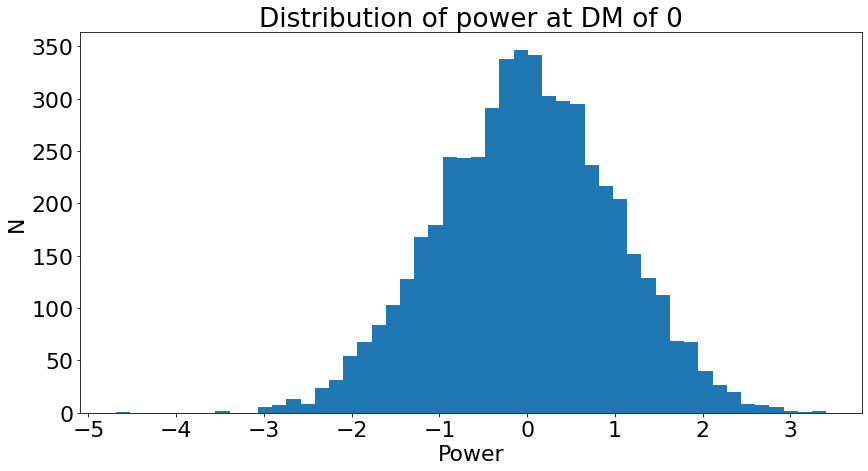

In [ ]:
plt.hist((np_dedisperse_timeseries[0]-np.median(np_dedisperse_timeseries[0]))/np.std(np_dedisperse_timeseries[0]),bins=50)
plt.xlabel("Power")
plt.ylabel("N")
plt.title("Distribution of power at DM of 0")

ดังนั้น การเก็บข้อมูลในแต่ละครั้ง จึงเปรียบเสมือนการสุ่ม 1 ครั้ง ดังนั้นเราสามารถคำนวณได้ว่า ถ้าเราสุ่มจำนวณ N ครั้ง จะมีความน่าจะเป็น 1/N ครั้ง ที่จะมีสัญญาณ (ที่เกิดจากสัญญาณรบกวนล้วนๆ) มี power $\mu+x \sigma$ โดยในกรณีของเรานั้น เราได้ Normalized ให้สัญญาณของเรา มีค่า $\mu$=0 แลt $\sigma$=1 เรียบร้อยแล้ว 

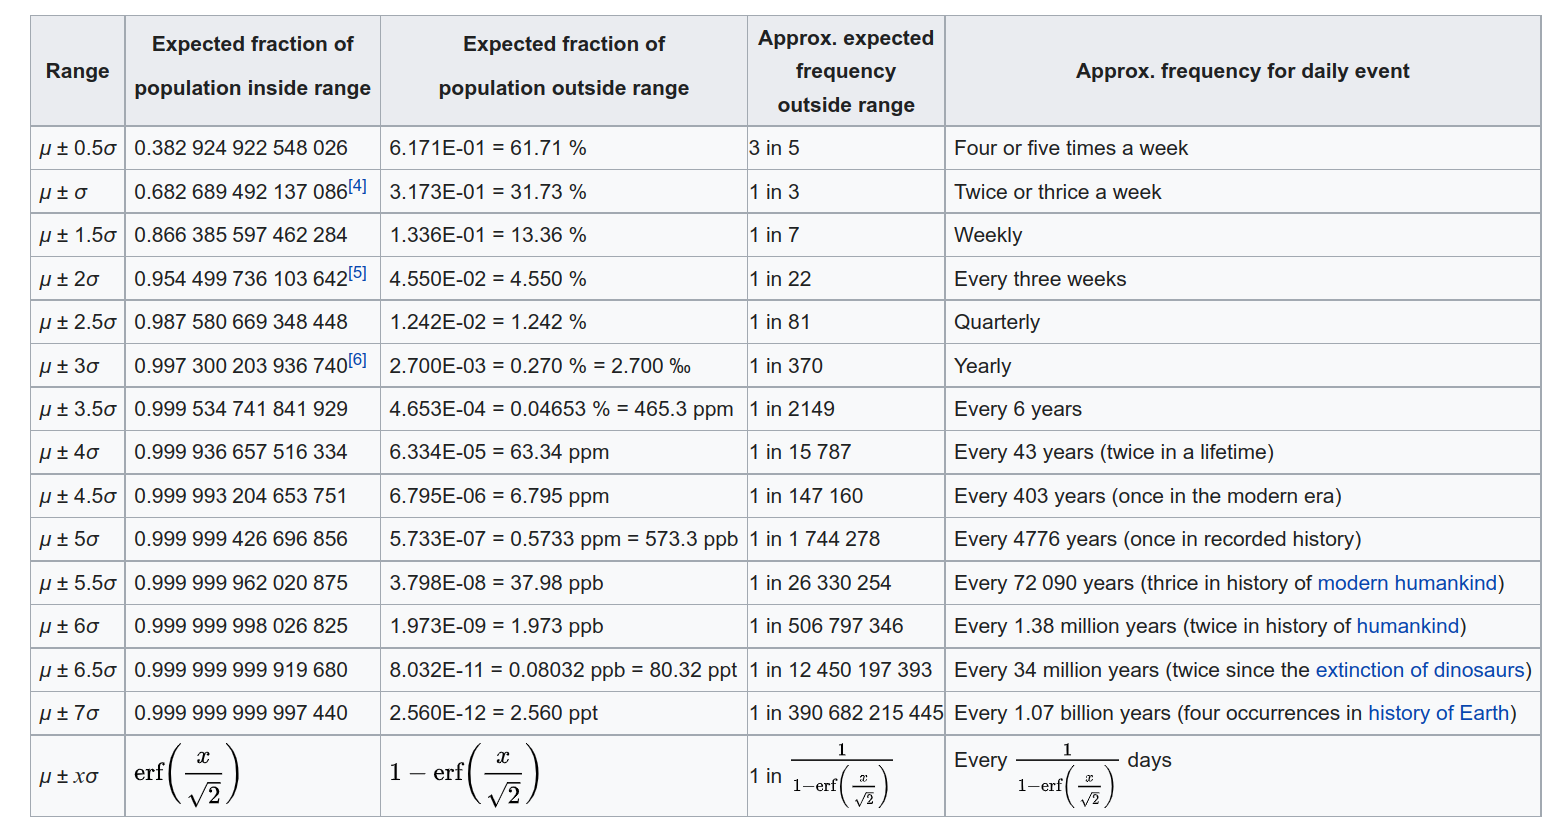

EX 4 สำหรับข้อมูลนี้ มีจำนวณข้อมูลเท่าไหร่ ดังนั้น normalized power มากที่สุดที่เป็นไปได้จากสัญญาณรบกวน จะมีค่า x=???

S/N Bins time Width
7.735933958861862 1601 2.0276164687500002 1
13.908266852323623 1602 2.0288829375 1
5.27096286752523 1603 2.03014940625 1
6.890517853398978 1600 2.02635 2
14.471411500509355 1601 2.0276164687500002 2
12.823966798255578 1602 2.0288829375 2
5.282424439335242 1598 2.0238170625 4
11.046885718761123 1599 2.02508353125 4
13.034975484109044 1600 2.02635 4
11.794916980974316 1601 2.0276164687500002 4
8.548036710933742 1602 2.0288829375 4
7.600095392433718 1595 2.02001765625 8
9.196843450342513 1596 2.021284125 8
8.791112386447654 1597 2.02255059375 8
9.046330313736355 1598 2.0238170625 8
9.081504579356274 1599 2.02508353125 8
8.90481524507948 1600 2.02635 8
8.003372437796953 1601 2.0276164687500002 8
5.973899112145457 1602 2.0288829375 8
4.447281125985089 1588 2.011152375 16
4.639291725817661 1589 2.01241884375 16
5.09433054459896 1590 2.0136853125 16
5.378401021063586 1591 2.01495178125 16
5.488872873022052 1592 2.01621825 16
5.558312322824516 1593 2.01748471875 16
6.066482

Text(0, 0.5, 'S/N')

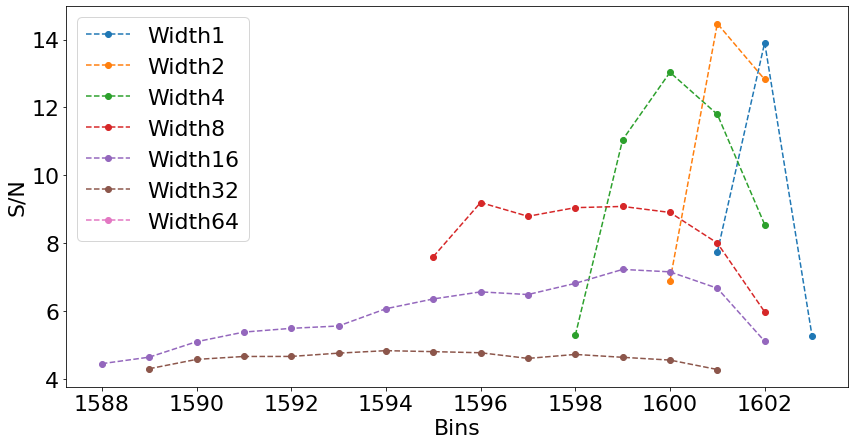

In [ ]:
x=4.0
print("S/N","Bins","time","Width")
for j in range(0,len(i_array)):
  # Get the indices of the elements greater than or equal to x
  indices = np.where(np.array(width[j]) >= 4)[0]
  values = [width[j][i] for i in indices]

  # Plot the values using the original indices
  plt.plot(indices, values, '--o', label='Width'+str(i_array[j]))
  for i in range(0,len(values)):
    print(values[i],indices[i],indices[i]*myFil.header.tsamp,i_array[j])

plt.legend()
plt.xlabel("Bins")
plt.ylabel("S/N")

จะเห็นว่า bins ที่มี S/N สูงที่สุด อยู่ที่ bins ที่ 1601  

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

CPU times: user 3.05 s, sys: 96.6 ms, total: 3.15 s
Wall time: 3.37 s


Text(0, 0.5, 'S/N')

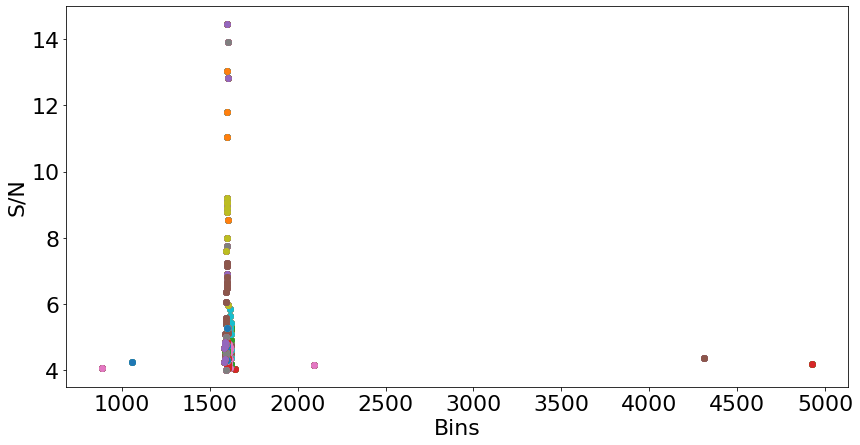

In [ ]:
%%time
dedisperse_timeseries=[]
dm_step=np.arange(0,525,25)
#print("S/N","Bins","time","Width")
data=[]
for i in dm_step:
  myTim=myFil.dedisperse(i)
  width=[]
  i_array=[1, 2, 4, 8, 16, 32, 64]
  for i in i_array:
  # Perform the convolution and calculate the width
    p = convolve(1/np.ones(i), myTim, mode='valid')
    norm_p=(p-np.median(p))/p.std()
    x=4.0
    
    for j in range(0,len(i_array)):
  # Get the indices of the elements greater than or equal to x
      indices = np.where(np.array(norm_p >= 4))[0]

  # Get the values of the elements greater than or equal to x
      values = [norm_p[i] for i in indices]

  # Plot the values using the original indices
      plt.plot(indices, values, 'o', label='Width'+str(i_array[j]))
      for i in range(0,len(values)):
        #print(values[i],indices[i],indices[i]*myTim.header.tsamp,i_array[j])
        data.append((values[i],indices[i],indices[i]*myTim.header.tsamp,i_array[j]))
#plt.legend()
plt.xlabel("Bins")
plt.ylabel("S/N")

EX5: ในข้อมูลนี้ มีสัญญาณที่ Bins ที่เท่าไหร่ และ วินาทีที่เท่าไหร่ (คำใบ้ t=bins*tsamp)

In [ ]:
1602*0.00126646875

2.0288829375

# Look at the pulse

หลังจากที่เรา Detect สัญญาณได้แล้ว เราจะมาดูกันว่า pulse ดังกล่าวมีอยู่จริงหรือไม่ โดยใช้ package ชื่อว่า your

In [ ]:
cand = Candidate(
    fp=fil_file,
    dm=475,
    tcand=2.0288829375,
    width=2,
    label=-1,
    snr=14.47,
    min_samp=256,
    device=0,
)

In [ ]:
cand.get_chunk()

Using <class 'str'>:
/tmp/tmpkoooe5zp/FRB180417.fil

ถ้าเราพล็อต สัญญาณโดยไม่ Dedisperse จะได้

In [ ]:
cand.get_chunk()
plt.imshow(cand.data.T, aspect="auto", interpolation=None, cmap='gray')
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

AttributeError: ignored

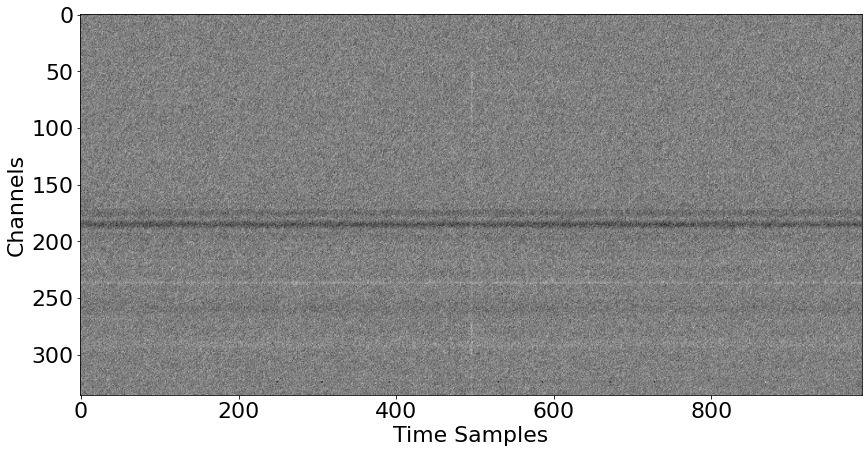

In [ ]:
cand.dedisperse()
plt.imshow(cand.dedispersed.T, aspect="auto", interpolation=None,cmap='gray')
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

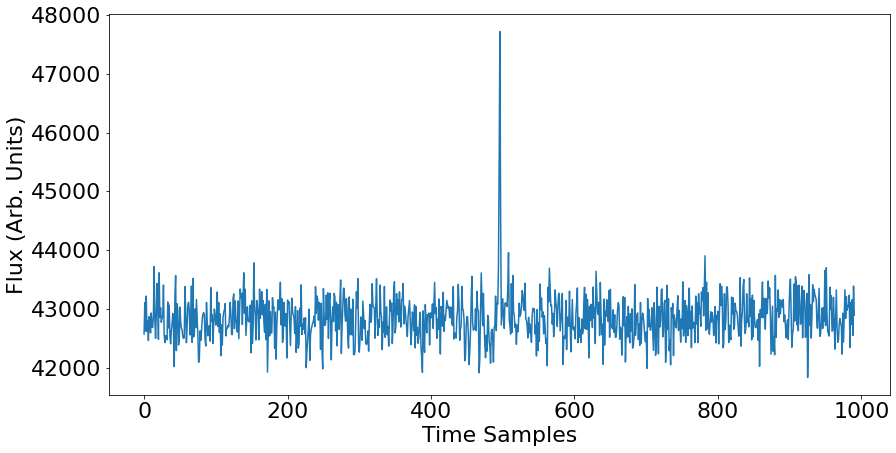

In [ ]:
plt.plot(cand.dedispersed.T.sum(0))
plt.xlabel("Time Samples")
plt.ylabel("Flux (Arb. Units)")
plt.show()

# Find your own burst !!!! 

PSR B0329+54 is the brighest pulsar in the northern sky, it is bright enougn that we can detect each single pulse of them. Radio measurments shows that this pulsar has a DM of 26.7641. With the provided data, find each pulse. 

In [ ]:

temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/B0329%2B54.fil"
url = "https://zenodo.org/record/3905426/files/B0329%2B54.fil"
urlretrieve(
    url,
    download_path,
)
fil_file = download_path

In [ ]:
myFil = FilReader(fil_file)
Pretty(myFil.header)

Header(
    filename='/tmp/tmphqv6ld6f/B0329%2B54.fil',
    data_type='raw data',
    nchans=4096,
    foff=-0.234375,
    fch1=1919.8828125,
    nbits=8,
    tsamp=0.000256,
    tstart=58458.48909080546,
    nsamples=8192,
    nifs=1,
    coord=<SkyCoord (ICRS): (ra, dec) in deg
    (53.25831042, 54.57872008)>,
    azimuth=<Angle -1. deg>,
    zenith=<Angle -1. deg>,
    telescope='GBT',
    backend='FAKE',
    source='TEMP',
    frame='topocentric',
    ibeam=0,
    nbeams=1,
    dm=0,
    period=0,
    accel=0,
    signed=False,
    rawdatafile='./B0329+54.fil',
    hdrlens=[392],
    datalens=[33554432],
    filenames=['/tmp/tmphqv6ld6f/B0329%2B54.fil'],
    nsamples_files=[8192],
    tstart_files=[58458.48909080546]
)

In [ ]:
%%time
dedisperse_timeseries=[]
dm_step=np.arange(0,100,2)
for i in dm_step:
  dedisperse_timeseries.append(myFil.dedisperse(i))
np_dedisperse_timeseries=np.asarray(dedisperse_timeseries)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

CPU times: user 15.7 s, sys: 788 ms, total: 16.5 s
Wall time: 11.8 s


<timed exec>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


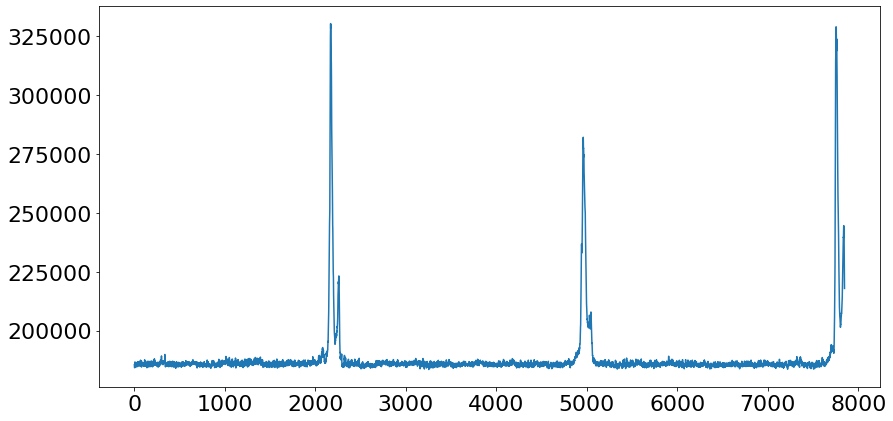

In [ ]:
plt.plot(np_dedisperse_timeseries[13])

In [ ]:
%%time
width=[]
i_array=[1, 2, 4, 8, 16, 32, 64]
for i in i_array:
    # Perform the convolution and calculate the width
    p = convolve(1/np.ones(i), np_dedisperse_timeseries[13], mode='valid')
    width.append((p-np.median(p))/p.std())

CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 7.07 ms


In [ ]:
0.000256*2000

0.512

S/N Bins time Width
6.441014475082744 2162 0.553472 1
7.562852055116183 2163 0.553728 1
8.736746882915618 2164 0.5539839999999999 1
9.723733625313075 2165 0.55424 1
10.480547962790029 2166 0.554496 1
10.779118455582449 2167 0.554752 1
11.102900530252569 2168 0.555008 1
11.240474841239537 2169 0.555264 1
11.083369335649781 2170 0.55552 1
11.201879333179845 2171 0.5557759999999999 1
10.927041965303165 2172 0.556032 1
10.58442901774908 2173 0.556288 1
10.552992353926266 2174 0.5565439999999999 1
10.243061086584019 2175 0.5568 1
10.063700913040488 2176 0.557056 1
9.921457790594687 2177 0.557312 1
9.566316865626064 2178 0.557568 1
8.659555866796234 2179 0.557824 1
8.025609084210924 2180 0.55808 1
7.7635331343217215 2181 0.5583359999999999 1
7.514218602419998 2182 0.558592 1
7.297819191303053 2183 0.558848 1
7.198762574851464 2184 0.5591039999999999 1
6.875447381327226 2185 0.55936 1
6.405609321519922 2186 0.559616 1
6.452764317254142 2187 0.5598719999999999 1
6.243445936849763 4955 1.26848 

Text(0, 0.5, 'S/N')

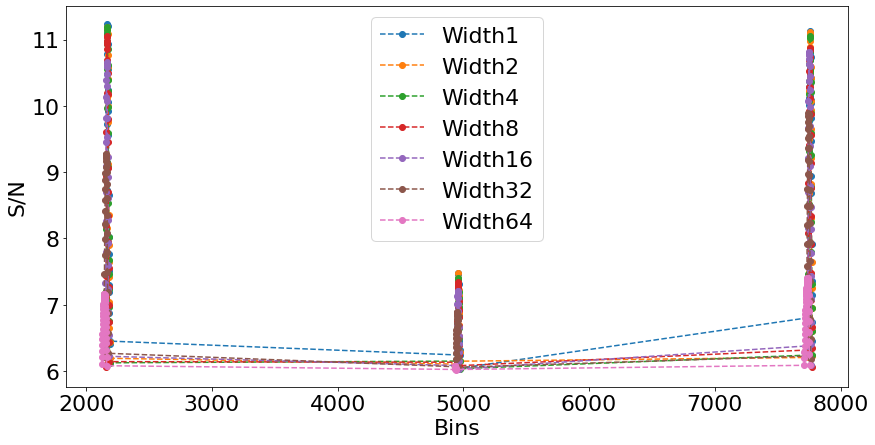

In [ ]:
x=6.0
print("S/N","Bins","time","Width")
for j in range(0,len(i_array)):
  # Get the indices of the elements greater than or equal to x
  indices = np.where(np.array(width[j]) >= 6)[0]
  values = [width[j][i] for i in indices]

  # Plot the values using the original indices
  plt.plot(indices, values, '--o', label='Width'+str(i_array[j]))
  for i in range(0,len(values)):
    print(values[i],indices[i],indices[i]*myFil.header.tsamp,i_array[j])

plt.legend()
plt.xlabel("Bins")
plt.ylabel("S/N")

In [ ]:
cand = Candidate(
    fp=fil_file,
    dm=26,
    tcand= 1.270016 ,
    width=2,
    label=-1,
    snr=14.47,
    min_samp=256,
    device=0,
)

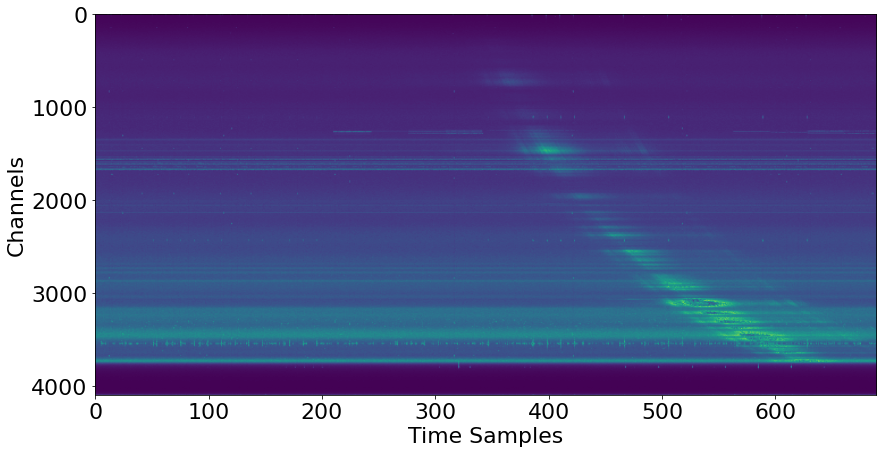

In [ ]:
cand.get_chunk()
plt.imshow(cand.data.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

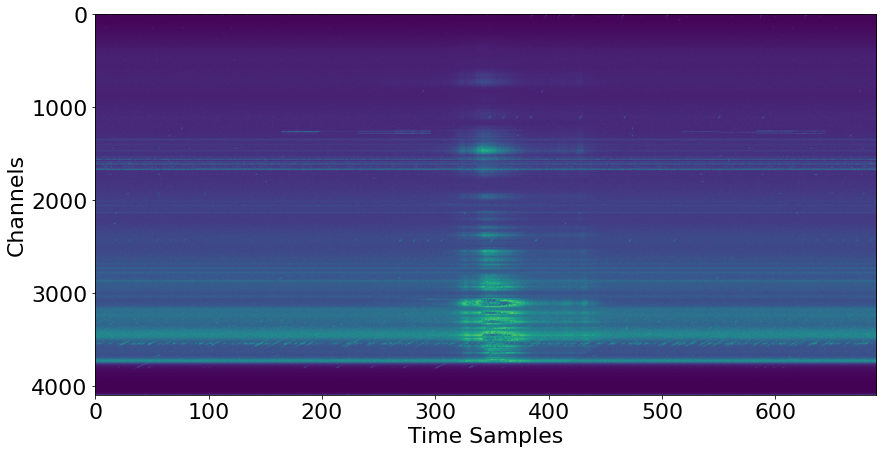

In [ ]:
cand.dedisperse()
plt.imshow(cand.dedispersed.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

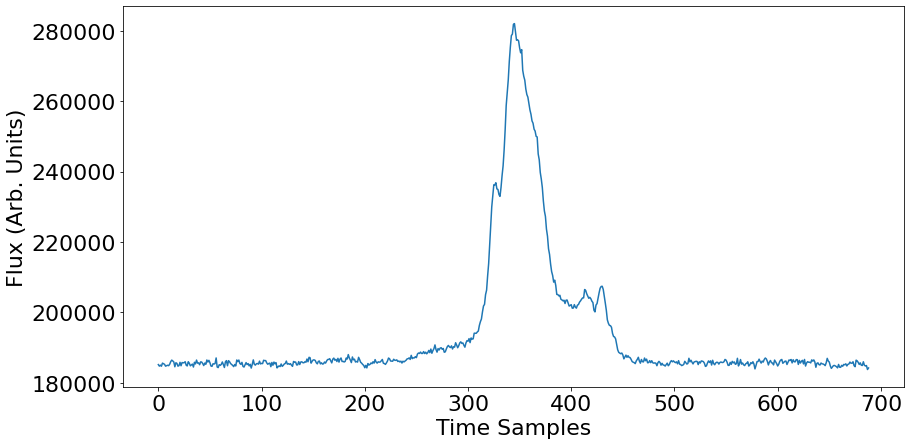

In [ ]:
plt.plot(cand.dedispersed.T.sum(0))
plt.xlabel("Time Samples")
plt.ylabel("Flux (Arb. Units)")
plt.show()